# MODEL PERFORMANCE TESTING

In [3]:
# the sampler
# !pip install git+https://github.com/justinalsing/affine.git
# to create triangle plots
# !pip install getdist

In [5]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import trange
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.models import model_from_json

mpl.rcParams['lines.linewidth'] = .7

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


In [6]:
# training dataset from inverse problem

# # drive
# from google.colab import drive
# drive.mount('/content/drive')
# training_path = '/content/drive/My Drive/cdt2022/Public/TrainingData/'

# local
training_path = 'Level2Data/'


Mounted at /content/drive


## MODEL TRAINING/TESTING

The model designed is a simple dense neural network, that takes as input the target (6 parameters) and the auxiliary (9 parameters) parameters through two parallel branches constituted of dense layers, which then are concatenated to yield a spectrum as output (size `(52,1)`).

The data is normalized:
* for the parameters, we subtract the mean, divide by the standard deviation, and divide by the maximum (of the absolute values) so that all parameters lie in the `[-1;1]` range.
* for the spectra, we first take the logarithm of the data to reduce the dynamic range. We then perform the same normalization *along each wavelength* (so in total 52 means, standard deviations and maxima obtained from $\log(data)$). 

  <!-- but go back to normal space to measure accuracy  -->

In [7]:
fmparam = pd.read_csv(os.path.join(training_path, 'Ground_Truth_Package/FM_Parameter_Table.csv'))
tracedata = h5py.File(os.path.join(training_path, 'Ground_Truth_Package/Tracedata.hdf5'), 'r')
aux = pd.read_csv(os.path.join(training_path, 'AuxillaryTable.csv'))
spectra = h5py.File(os.path.join(training_path, 'SpectralData.hdf5'), 'r')

spectra_idx = list(spectra.keys())

In [8]:
yspec = np.zeros((len(spectra), 52))
dyspec = np.zeros((len(spectra), 52))
for p in range(len(yspec)):
    yspec[p] = spectra['Planet_'+str(p)]['instrument_spectrum'] # ordered
    dyspec[p] = spectra['Planet_'+str(p)]['instrument_noise'][:] # ordered

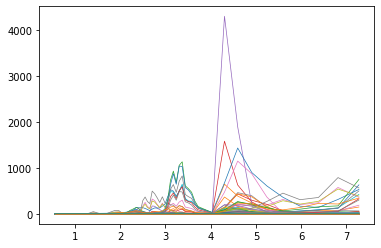

In [ ]:
# distribution before normalisation: a wide dynamic range
# do not run if in a rush! takes quite long
plt.figure()
w = spectra['Planet_0']['instrument_wlgrid'][:] # the wavelength spacing is the same for all spectra
for ys in yspec:
  plt.plot(w,ys)

Index(['planet_temp', 'log_H2O', 'log_CO2', 'log_CH4', 'log_CO', 'log_NH3'], dtype='object')
Index(['star_distance', 'star_mass_kg', 'star_radius_m', 'star_temperature',
       'planet_mass_kg', 'planet_orbital_period', 'planet_distance',
       'planet_radius_m', 'planet_surface_gravity'],
      dtype='object')



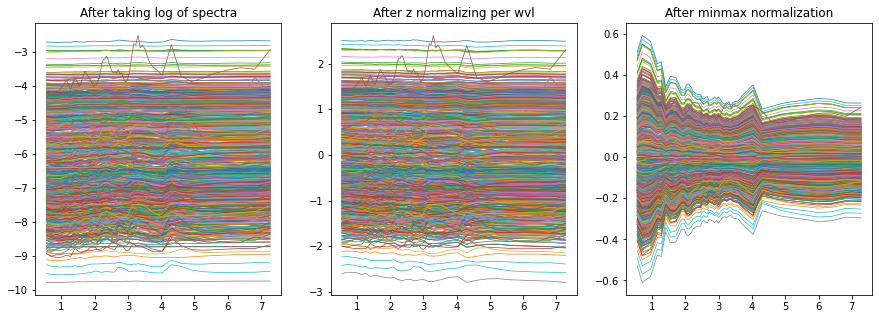

In [9]:
# CREATING THE TRAINING AND TESTING DATASET // NORMALIZATION

def processdata(param, aux, yspectra, dyspectra):

  param.drop('planet_ID', inplace=True, axis=1)
  pkeys = param.keys()
  aux.drop('planet_ID', inplace=True, axis=1)
  akeys = aux.keys()
  print(pkeys); print(akeys); print()

  # NORMALISATION: ZSCORE
  # (-mean) / stdev standardization
  
  # normalisation of inputs
  means = []; stdevs = []; maxis = []
  
  for p in pkeys:
    mean = np.mean(param[p]); means.append(mean)
    stdev = np.std(param[p]); stdevs.append(stdev)
    param[p] = (param[p]-mean) / stdev
    # and restrict to -1,1 range
    max = np.max(np.abs(param[p])); maxis.append(max)
    param[p] = param[p] / max
  
  for a in akeys:
    mean = np.mean(aux[a]); means.append(mean)
    stdev = np.std(aux[a]); stdevs.append(stdev)
    aux[a] = (aux[a]-mean) / stdev
    # and restrict to -1,1 range
    max = np.max(np.abs(aux[a])); maxis.append(max)
    aux[a] = aux[a] / max

  # normalisation of spectra
  # 1 - take log of spectra
  logyspectra = np.log(yspectra)
  logdyspectra = dyspectra/yspectra # if z=log(y) than Dz = 1/y * Dy

  plt.figure(figsize=(15,5))
  w = spectra['Planet_0']['instrument_wlgrid'][:]
  plt.subplot(131)
  plt.title('After taking log of spectra')
  for ys in logyspectra[:1000]:
    plt.plot(w,ys)

  # 2 - subtract mean and divide by stdev for each wavelength (axis 0)
  meanwvl = np.mean(logyspectra, axis=0); means.append(meanwvl)
  stdevwvl = np.std(logyspectra, axis=0); stdevs.append(stdevwvl)
  logyspectra = ((logyspectra-meanwvl) / stdevwvl)
  logdyspectra = ((logdyspectra) / stdevwvl) # we don't "recenter" the errors (-mean), otherwise we'd get neg val

  plt.subplot(132)
  plt.title('After z normalizing per wvl')
  for ys in logyspectra[:1000]:
    plt.plot(w,ys)

  # 3 - minmax normalisation
  maxwvl = np.amax(np.abs(logyspectra), axis=0); maxis.append(maxwvl)
  logyspectra = logyspectra / maxwvl
  logdyspectra = logdyspectra / maxwvl

  plt.subplot(133)
  plt.title('After minmax normalization')
  for ys in logyspectra[:1000]:
    plt.plot(w,ys)

  # now split dataset into training and testing datasets

  # # OLD VERSION
  # # let's take 80% of the dataset for training and 20% for testing.
  # r = int(0.8*len(param))
  # train_param = param[0:r]; train_aux = aux[0:r]; train_spectra = logyspectra[0:r]; train_dspectra = logdyspectra[0:r]
  # test_param = param[r:]; test_aux = aux[r:]; test_spectra = logyspectra[r:]; test_dspectra = logdyspectra[r:]

  # NEW VERSION
  # let's keep the spectra that don't have sampled param distributions for training, 
  # and those with provided distributions for testing.
  # this way we can plot these distrib in the triangle plots against our own estimates.
  r = 21988 # all planets before that index have trace data, the others dont
  test_param = param[0:r]; test_aux = aux[0:r]; test_spectra = logyspectra[0:r]; test_dspectra = logdyspectra[0:r]
  train_param = param[r:]; train_aux = aux[r:]; train_spectra = logyspectra[r:]; train_dspectra = logdyspectra[r:]
  

  return train_param, train_aux, train_spectra, train_dspectra, test_param, test_aux, test_spectra, test_dspectra, means, stdevs, maxis


train_p, train_a, train_s, train_ds, test_p, test_a, test_s, test_ds, means, stdevs, maxis = processdata(fmparam, aux, yspec, dyspec)


# print('means:', means)
# print()
# print('stdev:', stdevs)
# print()
# print('maxis:', maxis)

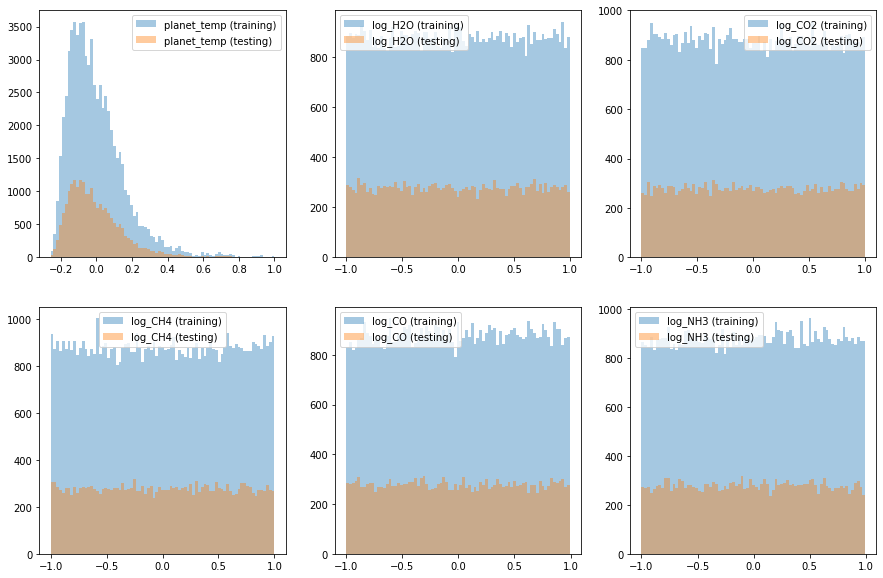

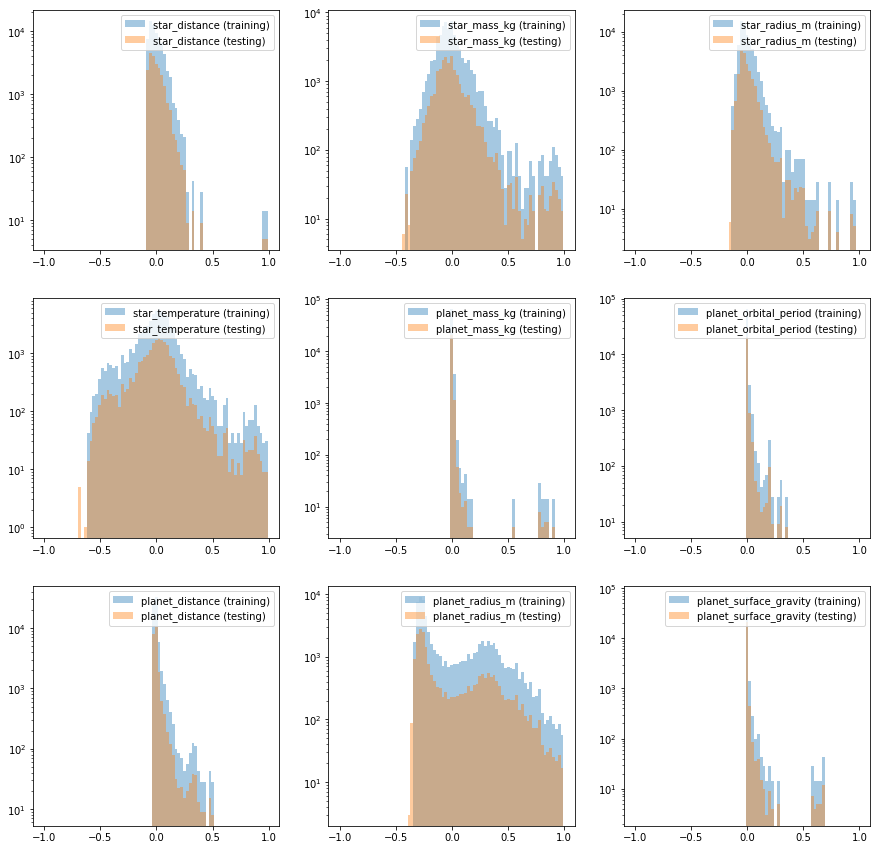

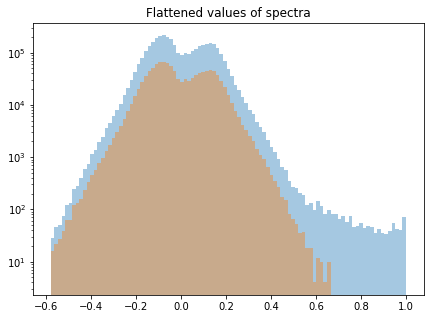

In [10]:
# SOME HISTOGRAMS 

plt.figure(figsize=(15,10))
i=1
for p in train_p.keys():
  plt.subplot(2,3,i)
  bins = np.linspace(np.min(list(train_p[p])+list(test_p[p])), np.max(list(train_p[p])+list(test_p[p])), 80)
  plt.hist(train_p[p], bins = bins, label=p+' (training)', alpha=0.4)
  plt.hist(test_p[p], bins=bins, label=p+' (testing)', alpha=0.4)
  plt.legend();
  i+=1

plt.figure(figsize=(15,15))
i=1
for a in train_a.keys():
  plt.subplot(3,3,i)
  bins = np.linspace(np.min(list(train_p[p])+list(test_p[p])), np.max(list(train_p[p])+list(test_p[p])), 80)
  plt.hist(train_a[a], bins=bins, log=True, label=a+' (training)', alpha=0.4)
  plt.hist(test_a[a], bins=bins, log=True, label=a+' (testing)', alpha=0.4)
  plt.legend();
  i+=1

plt.figure(figsize=(7,5))
flat_s_train = train_s.flatten()
flat_s_test = test_s.flatten()
bins = np.linspace(np.min(flat_s_train), np.max(flat_s_train), 100)
plt.hist(flat_s_train, bins=bins, log=True, alpha=0.4)
plt.hist(flat_s_test, bins=bins, log=True, alpha=0.4)
plt.title('Flattened values of spectra');

In [11]:
branchone = tf.keras.models.Sequential()
# input layer: indicate the shape of your input
branchone.add(tf.keras.Input(shape=(6,))) # since matrix of x,y,dz,dy ? (is y relevant to training tho?)
# some dense layers
branchone.add(tf.keras.layers.Dense(512, activation='relu'))
branchone.add(tf.keras.layers.Dense(512, activation='relu'))
branchone.add(tf.keras.layers.Dense(512, activation='relu'))
branchone.add(tf.keras.layers.Dense(256, activation='relu'))
branchone.add(tf.keras.layers.Dense(128, activation='relu'))
branchone.add(tf.keras.layers.Dense(64, activation='relu'))
branchone.summary()


branchtwo = tf.keras.models.Sequential()
# input layer: indicate the shape of your input
branchtwo.add(tf.keras.Input(shape=(9,)))
# DENSE VERSION
# some dense layers
branchtwo.add(tf.keras.layers.Dense(512, activation='relu')) # , kernel_initializer='normal'
branchtwo.add(tf.keras.layers.Dense(512, activation='relu'))
branchtwo.add(tf.keras.layers.Dense(512, activation='relu'))
branchtwo.add(tf.keras.layers.Dense(512, activation='relu'))
branchtwo.add(tf.keras.layers.Dense(256, activation='relu')) # added
branchtwo.add(tf.keras.layers.Dense(128, activation='relu'))
branchtwo.add(tf.keras.layers.Dense(64, activation='relu'))
branchtwo.summary()


def combined(modelbranch1, modelbranch2):
  
  # concatenate the output of the two branches
  z = tf.keras.layers.concatenate([modelbranch1.output, modelbranch2.output])

  # # TREE TRUNK: dense layers
    # apply dense layers + binary prediction on the combined outputs of the 2 branches
    # you can add some more here, i mean why not right
  z = tf.keras.layers.Dense(512, activation="relu")(z)
  z = tf.keras.layers.Dense(512, activation="relu")(z)
  z = tf.keras.layers.Dense(512, activation="relu")(z)
  z = tf.keras.layers.Dense(256, activation="relu")(z)
  z = tf.keras.layers.Dense(212, activation="relu")(z)
  z = tf.keras.layers.Dense(192, activation="relu")(z)
  z = tf.keras.layers.Dense(128, activation="relu")(z)  
  z = tf.keras.layers.Dense(96, activation="relu")(z)
  z = tf.keras.layers.Dense(64, activation="relu")(z)

  # output layer: same shape as the number of points you want to obtain at the end
  z = tf.keras.layers.Dense(52, activation="linear")(z)
    # need to use linear if the target data is not constrained to an interval
    # i think tanh or linear work identically well, but at least we know that tanh is confined to the [-1;1] interval
  
  # two inputs (one for each branch), a single output in the form of a spectrum
  combined_model = tf.keras.Model(inputs=[modelbranch1.input, modelbranch2.input], outputs=z)
  # this function is just for the architecture, we'll deal with compiling later
  
  return combined_model

print()
parallel = combined(branchone,branchtwo)
parallel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3584      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
Total params: 701,376
Trainable params: 701,376
Non-trai

In [13]:
# COMPILING

opt = tf.keras.optimizers.Adam(0.001)
met = [tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
ls = tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
parallel.compile(loss=ls, optimizer=opt, metrics=met)


In [ ]:
# TRAINING

epo = 100
batchsz = 32 # was 32, 64, 128

def scheduler(epoch, lr):
  if epoch%20==0:
    return lr/10
  else:
    return lr

cb = [
    # tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 5e-7, patience=20),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
      ]

history = parallel.fit(
        [train_p,train_a], # train_pa,
        train_s, 
        batch_size=batchsz, 
        epochs=epo,
        validation_data=([test_p,test_a], test_s), # (test_pa, test_s),
        callbacks=cb, 
        verbose=2
        )



Epoch 1/100
2169/2169 - 16s - loss: 0.0015 - mape: 72.2042 - val_loss: 1.8537e-04 - val_mape: 52.8648 - lr: 1.0000e-04 - 16s/epoch - 7ms/step
Epoch 2/100
2169/2169 - 11s - loss: 6.1636e-04 - mape: 45.5466 - val_loss: 3.9580e-04 - val_mape: 44.8591 - lr: 1.0000e-04 - 11s/epoch - 5ms/step
Epoch 3/100
2169/2169 - 12s - loss: 5.6771e-04 - mape: 39.4978 - val_loss: 1.3392e-04 - val_mape: 39.6838 - lr: 1.0000e-04 - 12s/epoch - 6ms/step
Epoch 4/100
2169/2169 - 11s - loss: 5.4124e-04 - mape: 40.2394 - val_loss: 1.3559e-04 - val_mape: 33.8580 - lr: 1.0000e-04 - 11s/epoch - 5ms/step
Epoch 5/100
2169/2169 - 12s - loss: 5.3229e-04 - mape: 37.3721 - val_loss: 6.7084e-05 - val_mape: 28.3055 - lr: 1.0000e-04 - 12s/epoch - 6ms/step
Epoch 6/100
2169/2169 - 19s - loss: 5.0754e-04 - mape: 35.2882 - val_loss: 9.8474e-05 - val_mape: 32.8203 - lr: 1.0000e-04 - 19s/epoch - 9ms/step
Epoch 7/100
2169/2169 - 11s - loss: 4.8856e-04 - mape: 39.9259 - val_loss: 9.7114e-05 - val_mape: 30.6730 - lr: 1.0000e-04 - 11s

In [ ]:
# cell to compare with previous model
# previousmodelhist = history # comment out once you run it


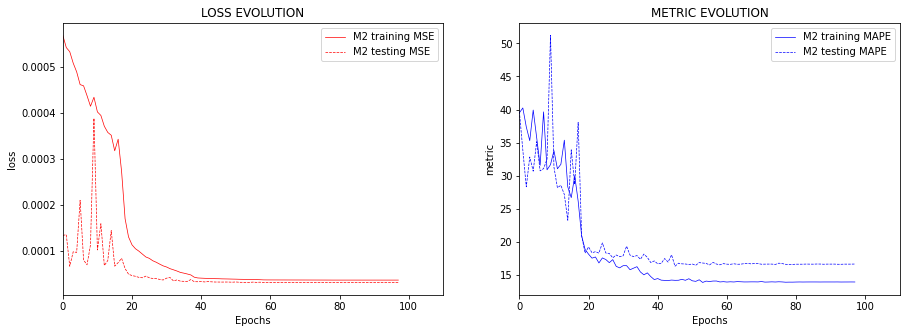

In [ ]:
# cell to compare with previous model

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.set_title('LOSS EVOLUTION')
ax1.set_xlabel('Epochs'); ax1.set_xlim(0,1.1*epo)
ax1.set_ylabel('loss'); #ax1.set_ylim(0,.0001)
ax1.plot(history.history['loss'][2:], 'r-', label='M2 training MSE');
ax1.plot(history.history['val_loss'][2:], 'r--', label='M2 testing MSE');

ax2 = fig.add_subplot(122)
ax2.set_title('METRIC EVOLUTION')
ax2.set_xlabel('Epochs'); ax2.set_xlim(0,1.1*epo)
ax2.set_ylabel('metric'); # ax2.set_ylim(0,10)
ax2.plot(history.history['mape'][2:], 'b-', label='M2 training MAPE');
ax2.plot(history.history['val_mape'][2:], 'b--', label='M2 testing MAPE');

# # previous model
# # comment out if not defined above
# # currently: comparison model is the 2 parallel branches, dense (only) nn, only output layer in tree trunk
# ax1.plot(previousmodelhist.history['loss'][2:], 'm-', label='M1 training MSE');
# ax1.plot(previousmodelhist.history['val_loss'][2:], 'm--', label='M1 testing MSE');
# ax2.plot(previousmodelhist.history['mape'][2:], 'c-', label='M1 training MAPE');
# ax2.plot(previousmodelhist.history['val_mape'][2:], 'c--', label='M1 testing MAPE');


ax1.legend();
ax2.legend();


Actually ignore the MAPE plot on the right, as MAPE can blow up for values close to zero (as is our case after the normalization steps, so MAPE is not a relevant metric here).

In [ ]:
# # Saving model so we can skip training later

# # serialize model to JSON
# model_json = parallel.to_json()
# with open("/content/drive/My Drive/cdt2022/parallel_v2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# parallel.save_weights("/content/drive/My Drive/cdt2022/parallel_v2.h5")
# print("Saved model to disk")

Saved model to disk


In [ ]:
# CUSTOM METRIC
# evaluate the accuracy using the uncertainty: if the predicted datapoint
# is within the error margin, then it is counted as an accurate prediction.

def uncacc(ypred,ytrue,dytrue):
    positives = 0
    for s in range(len(ypred)):
        pos_in_spectrum = np.where( (ypred[s]<(ytrue[s]+dytrue[s])) & (ypred[s]>(ytrue[s]-dytrue[s])) )
        # print(pos_in_spectrum)
        positives += len(pos_in_spectrum[0])
        total = (s+1)*52
        # print(positives, '/', total)
    # number of valid predictions over the total number of datapoints among all predicted spectra
    acc = positives / (52*len(ypred)) # max will be 1 if all lie within error bars

    return acc
    

Evaluate on test data
688/688 [==============================] - 2s 3ms/step - loss: 3.2041e-05 - mape: 16.6240
test loss, test metric: [3.204106542398222e-05, 16.624008178710938]
Generate predictions for 3 samples
predictions shape: (21988, 52)
0 0.07692307692307693
1 0.057692307692307696
2 0.2692307692307692
3 0.0
4 0.36538461538461536
5 0.019230769230769232
6 0.4807692307692308
7 0.11538461538461539
8 0.057692307692307696
9 0.057692307692307696
10 0.07692307692307693
11 0.6923076923076923
12 0.21153846153846154
13 0.6730769230769231
14 0.25
15 0.5192307692307693


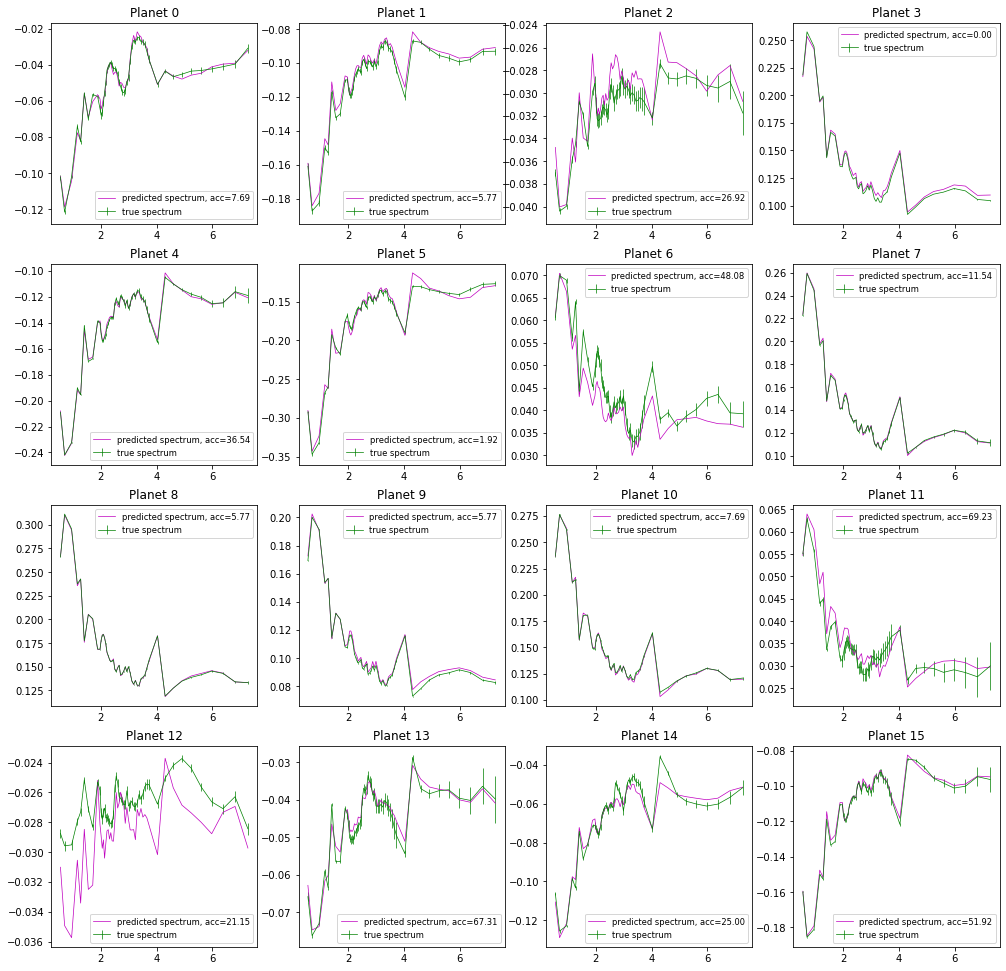

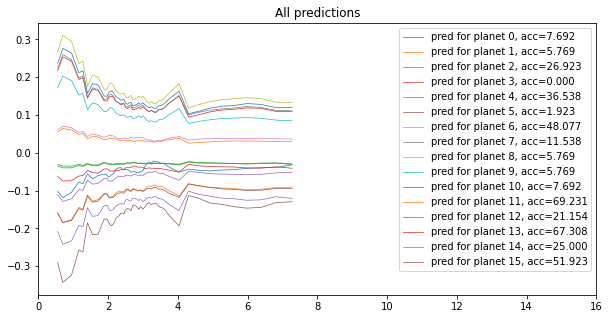

In [ ]:
# TEST NETWORK ON TESTING SAMPLE

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = parallel.evaluate([test_p, test_a], test_s, batch_size=batchsz)
# results = parallel.evaluate(test_pa, test_s, batch_size=batchsz)
print("test loss, test metric:", results)

# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions for 3 samples")
prediction = parallel.predict([test_p, test_a])
# prediction = parallel.predict(test_pa)
print("predictions shape:", prediction.shape)

wvl = spectra['Planet_0']['instrument_wlgrid'][:]

plt.figure(figsize=(17,17))
nplnt = 16
for s in range(nplnt):
    plt.subplot(4,4,s+1)
    plt.title('Planet {0}'.format(s))
    ua = uncacc([prediction[s]],test_s[s],test_ds[s])
    print(s, ua)
    plt.plot(wvl, prediction[s], 'm-', label='predicted spectrum, acc={0:.2f}'.format(ua*100))
    # plt.plot(wvl, test_s[s], 'g-', label='true spectrum')
    plt.errorbar(wvl, test_s[s], yerr=test_ds[s], color='g', linestyle='-', label='true spectrum')
    # plt.plot(wvl, test_s[s]+test_ds[s], color='g', linestyle='--', label='upper bound')
    # plt.plot(wvl, test_s[s]-test_ds[s], color='g', linestyle='--', label='lower bound')
    
    # pred_right_intensity = [p-prediction[s][0]+test_s[s][0] for p in prediction[s]]
    # plt.plot(wvl, pred_right_intensity, 'm--', alpha=0.3, label='predicted spectrum\n(intensity readjusted)')
    plt.legend(fontsize='small');

# prediction[s]



plt.figure(figsize=(10,5))
plt.title('All predictions')
for s in range(nplnt):
    ua = uncacc([prediction[s]],test_s[s],test_ds[s])
    plt.plot(wvl, prediction[s], label='pred for planet {0}, acc={1:.3f}'.format(s, ua*100))
    # plt.plot(np.concatenate((wvl,wvl)), np.concatenate((prediction[s], test_s[s])), label='pred for planet {0}, acc={1:.3f}'.format(s, ua*100))
    plt.xlim((0,2.2*np.max(wvl)))
    plt.legend();

In [ ]:
print(uncacc(prediction,test_s,test_ds))

# 0.32859165835532156 pred_withminmax_tanh
# 0.30302427754421846 pred_withoutminmax_linear
# 0.33097354256881584 pred_withoutmeanstdev_linear

0.3346222065182407


Evaluate on training data
2169/2169 [==============================] - 7s 3ms/step - loss: 3.7070e-05 - mape: 13.9119
test loss, test metric: [3.706956340465695e-05, 13.911924362182617]
Generate predictions for 3 samples
predictions shape: (69404, 52)
0 0.4230769230769231
1 0.25
2 0.4423076923076923
3 0.23076923076923078
4 0.3076923076923077
5 0.019230769230769232
6 0.15384615384615385
7 0.17307692307692307
8 0.4807692307692308
9 0.1346153846153846
10 0.09615384615384616
11 0.1346153846153846
12 0.07692307692307693
13 0.38461538461538464
14 0.19230769230769232
15 0.0


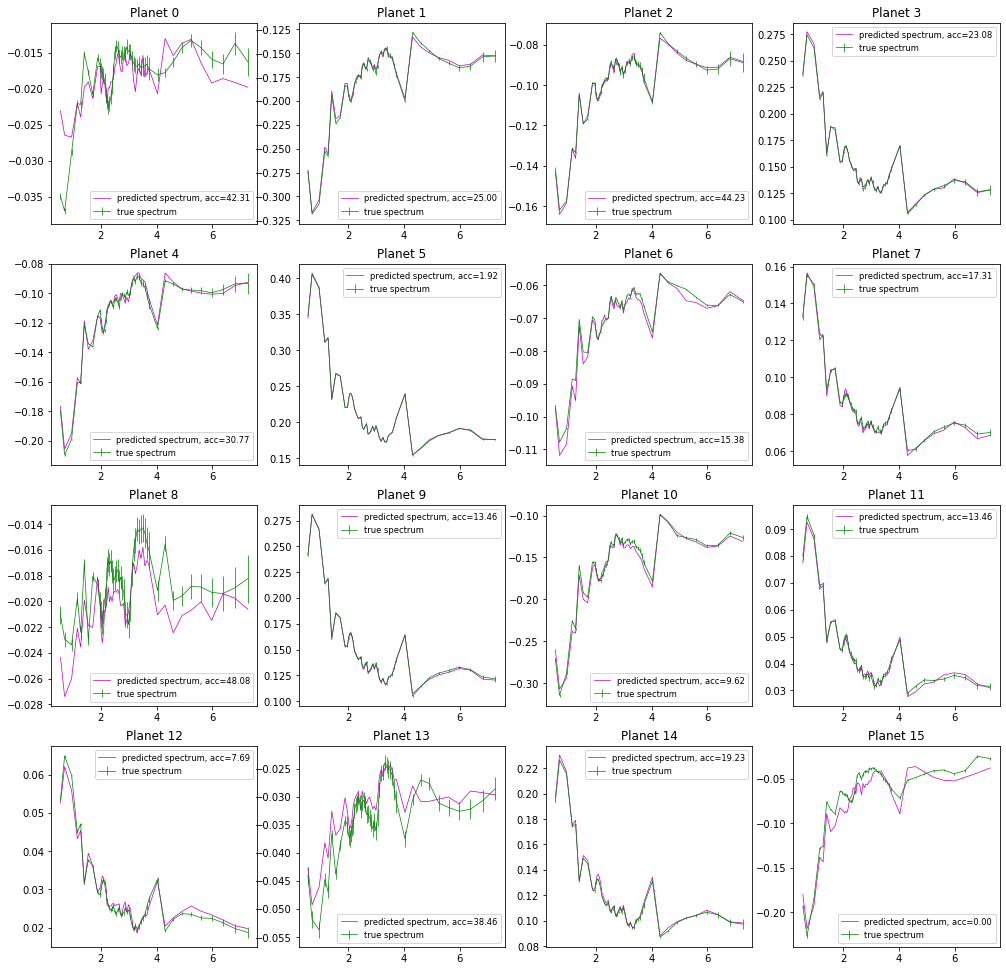

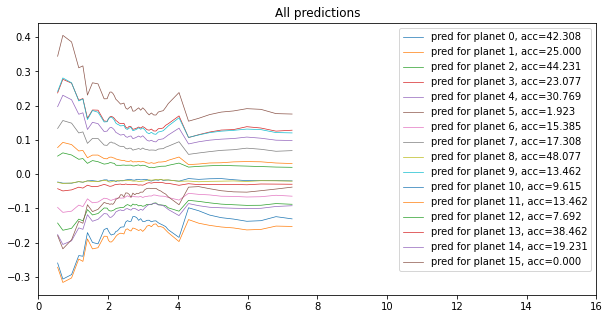

In [ ]:
# TEST NETWORK ON TRAINING SAMPLE

# Evaluate the model on the test data using `evaluate`
print("Evaluate on training data")
results = parallel.evaluate([train_p, train_a], train_s, batch_size=batchsz)
print("test loss, test metric:", results)

# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
print("Generate predictions for 3 samples")
prediction = parallel.predict([train_p, train_a])
print("predictions shape:", prediction.shape)

wvl = spectra['Planet_0']['instrument_wlgrid'][:]

plt.figure(figsize=(17,17))
nplnt = 16
for s in range(nplnt):
    plt.subplot(4,4,s+1)
    plt.title('Planet {0}'.format(s))
    ua = uncacc([prediction[s]],train_s[s],train_ds[s])
    print(s, ua)
    plt.plot(wvl, prediction[s], 'm-', label='predicted spectrum, acc={0:.2f}'.format(ua*100))
    # plt.plot(wvl, test_s[s], 'g-', label='true spectrum')
    plt.errorbar(wvl, train_s[s], yerr=train_ds[s], color='g', linestyle='-', label='true spectrum')
    # plt.plot(wvl, test_s[s]+test_ds[s], color='g', linestyle='--', label='upper bound')
    # plt.plot(wvl, test_s[s]-test_ds[s], color='g', linestyle='--', label='lower bound')
    
    # pred_right_intensity = [p-prediction[s][0]+test_s[s][0] for p in prediction[s]]
    # plt.plot(wvl, pred_right_intensity, 'm--', alpha=0.3, label='predicted spectrum\n(intensity readjusted)')
    plt.legend(fontsize='small');

# prediction[s]



plt.figure(figsize=(10,5))
plt.title('All predictions')
for s in range(nplnt):
    ua = uncacc([prediction[s]],train_s[s],train_ds[s])
    plt.plot(wvl, prediction[s], label='pred for planet {0}, acc={1:.3f}'.format(s, ua*100))
    # plt.plot(np.concatenate((wvl,wvl)), np.concatenate((prediction[s], test_s[s])), label='pred for planet {0}, acc={1:.3f}'.format(s, ua*100))
    plt.xlim((0,2.2*np.max(wvl)))
    plt.legend();

In [ ]:
print(uncacc(prediction,train_s,train_ds))

# 0.33113678615504555 pred_withminmaxtanh
# 0.30496523295341565 pred_withoutminmaxlinear

0.33783521676870765


## POSTERIOR INFERENCE

For now let us consider one exoplanet only. We know the real spectrum data ($data$ obtained from observations), and can obtain spectrum predictions from multiple sets of parameters through our emulator designed in the part above. From these we'll be able to obtain the posterior distribution.

Computing the (log)posterior:
1. Sample parameters using the affine sampler, and for each set of parameters obtain the emulated spectra (the so-called $theory$)
2. Compute the **log prior** (the prior is a uniform distribution in the original parameter space)
3. Compute the **log likelihood** - for this you need to know the covariance matrix $C$:
$$ \mathcal{L}ikelihood = - (data-theory)^T \times C^{-1} \times (data-theory) / 2 $$ note the likelihood has shape `(n_samples, 1)`
4. Sum the log prior and log likelihood: tada! you get the **log posterior**, as according to Bayes Theorem, $$P(\theta|D) = \frac{P(\theta)*P(D|\theta)}{P(D)} $$
(read: Posterior = Prior * Likelihood / Evidence), so if you take the logarithm on both sides you end up with a sum




### Get the tools you need

Get the covariance matrix, process the data, import the saved model, define the compiling parameters once more.

In [ ]:
# to run the cells below, first run: the data, spectra processing, and processdata() cells in MODEL TRAINING/TESTING to obtain
# --> fmparam, aux, spectra
# --> yspec, dyspec
# --> train_p, train_a, train_s, train_ds //// test_p, test_a, test_s, test_ds //// means, stdevs, maxis


In [14]:
# COVARIANCE MATRIX

# reduce the size of dataset bcs otherwise kernel crashes
covyspec = yspec[:2000]
# print(len(covyspec))

# estimate the data covariance matrix
cov_matrix = np.cov(covyspec, rowvar=False) # rowvar=True needed to get (52,52) shape
# print(cov_matrix)
print(np.shape(cov_matrix))

# plt.hist(cov_matrix.flatten()); # check the distribution of values

(52, 52)


In [15]:
# then run cell with loss, optimizer etc.
opt = tf.keras.optimizers.Adam(0.001)
met = [tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
ls = tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
batchsz = 64

In [16]:
# load json file and create model
json_file = open('emulator.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("emulator.h5")
print("Loaded model from disk!")


Loaded model from disk


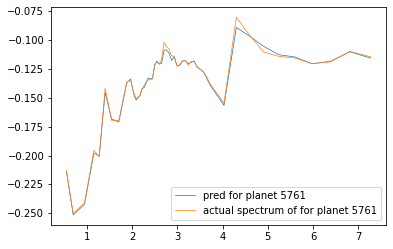

In [17]:
h = 5761
wvl = spectra['Planet_0']['instrument_wlgrid'][:]
pred = loaded_model.predict([np.array([test_p.iloc[h]]), np.array([test_a.iloc[h]])])
plt.plot(wvl, pred[0], label='pred for planet {0}'.format(h))
plt.plot(wvl, test_s[h], label='actual spectrum of for planet {0}'.format(h))
plt.legend(loc='lower right');

### Setting up the different elements


We create a `Spectrum` object which will be described by the spectrum data, and the corresponding auxiliary parameters. We also need to create methods that will:
* set the parameters priors
* compute the loglikelihood
* compute the logposterior (sum of loglikelihood and the logprior) 


In [18]:
# delayed processing: use same values used in processing of the dataset to obtain 
# an appropriate input for model predictions, using the sampled parameters (posterior inference)
# the samples are generated from the original parameter space, not the processed one.

# steps are: -mean/stdev, /max (no log step as e only want to reprocess the input params)
# we don't need to process the auxiliary params again, since we can just take them from test_a

def delayed_processing(input_p, means, stdevs, maxis): 
    nparams = input_p.shape[1]
    me = tf.constant(np.array(means[:nparams]))
    st = tf.constant(np.array(stdevs[:nparams]))
    ma = tf.constant(np.array(maxis[:nparams]))
    sub = tf.math.subtract(tf.cast(input_p, tf.float32), tf.cast(me, tf.float32)); #print('after subtraction:', sub.dtype, sub.shape)
    div = tf.math.divide(tf.cast(sub, tf.float32), tf.cast(st, tf.float32)); #print('after first division:', div.dtype, div.shape)
    output_p = tf.math.divide(tf.cast(div, tf.float32), tf.cast(ma, tf.float32))
    return output_p


In [19]:
# ok i think input_a and spectrum_vector data are fixed for one instance (one exoplanet);
# so if we're thinking of classes: one instance would have one spectrum and fixed auxiliary parameters 
# as attributes which we can easily call --> so use self.spectrum and self.aux


class Spectrum():

    def __init__(self, data, auxiliary):
        self.spectrum = data # data is just the y values, already processed (? can implement processing inside)
        self.aux = auxiliary # array of the 9 aux params, already processed
        self.params_and_priors = {  'planet_temp':     [100, 5500, 'uniform'],
                                    'log_H2O':         [-9, -3,    'uniform'],
                                    'log_CO2':         [-9, -4,    'uniform'],
                                    'log_CH4':         [-9, -3,    'uniform'],
                                    'log_CO':          [-6, -3,    'uniform'],
                                    'log_NH3':         [-9, -4,    'uniform'],
                                    }
        self.set_priors(self.params_and_priors)
        print('self.priors:', self.priors)
        

    def set_priors(self, parameters):
        """Prior distributions for all parameters"""
        model = []
        for p in parameters:
                low, high, name = parameters[p]
                if name=='uniform':
                    model.append(tfp.distributions.Uniform(low=low, high=high))
                elif name=='gaussian':
                    model.append(tfp.distributions.Normal(loc=low, scale=high))
        self.priors = tfp.distributions.Blockwise(model)

    def get_loglkl(self, sampled_p):
    # parameters:
        # input_a is fixed to the known auxiliary parameters values, already processed (from test_a)
        # sampled_p is sampled from prior (uninformative) distributions, not processed
        input_p = delayed_processing(sampled_p, means, stdevs, maxis) # use the same processing as in training
        input_a = self.aux
        input_s = self.spectrum
        input_s = input_s.reshape(52,1); #print('shape of spectrum with extra brackets', input_s) # need to tile!!
        t = tf.constant([1, input_p.shape[0]])
        spectrum_vector_data = tf.tile(tf.constant(input_s), t)
        tiled_aux = np.repeat(np.array([input_a]), sampled_p.shape[0], axis=0); # print('tiled aux param shape:', tiled_aux.shape)
        # theory_vector = loaded_model.predict([input_p, tiled_aux]) # no need to use .predict() in tf fct
        theory_vector = loaded_model([input_p, tiled_aux]) # ([input_p, input_a])
        # theory_vector = tf.reshape(theory_vector, (52, -1)) # change shape order with reshape?
        theory_vector = tf.transpose(theory_vector) # or transpose only? same end result
        inverse_cov_matrix = tf.linalg.inv(cov_matrix)
        print('data shape, prediction shape, inverse cov matrix shape:\n', spectrum_vector_data.shape, theory_vector.shape, inverse_cov_matrix.shape)
        print()

        # likelihood by steps to look at shapes
        print('checking the 5 steps shapes (towards calculating likelihood)')
        step1 = tf.math.subtract(tf.cast(spectrum_vector_data, tf.float32), tf.cast(theory_vector, tf.float32)); print('after subtracting:', step1.shape)
        step2 = tf.transpose(step1); print('after transposing:', step2.shape)
        step3 = tf.linalg.matmul(tf.cast(step2, tf.float32), tf.cast(inverse_cov_matrix, tf.float32)); print('after matrix multiplication:', step3.shape)
        step4 = tf.linalg.matmul(step3, step1); print('after second matrix multiplication:', step4.shape)
        step5 = tf.linalg.diag_part(step4); print('after keeping diagonal only:', step5.shape)
        lkl = tf.scalar_mul(-0.5, step5); print('after multiplying by scalar:', lkl.shape)

        # np version
        # lkl = - 0.5 * np.dot(np.dot((spectrum_vector_data - theory_vector).T, inverse_cov_matrix, axes=1), (spectrum_vector_data - theory_vector), axes=1)
        
        loglkl = tf.math.log(lkl)
        loglkl = tf.reshape(loglkl, [sampled_p.shape[0], 1])

        return loglkl


    def loglkl(self, parameters, prodpri):
        # check for parameters beyond prior ranges
        loglike = self.get_loglkl(parameters)
        loglike = tf.where(tf.equal(prodpri, 0.), -0.5*2e12, loglike) # i'm not sure about this line actually ?
        return loglike


    def posterior(self, sampled_p): # params, 
        pr = tf.reshape((self.priors).prob(sampled_p), [sampled_p.shape[0], 1])
        logprodPri, loglike  = tf.math.log(pr), self.loglkl(sampled_p, pr) # (params, pr)
        logprodPri = tf.where(tf.math.is_inf(logprodPri), -1e32, logprodPri)
        sum_loglkl_logpr = tf.add(loglike, logprodPri)
        return sum_loglkl_logpr
    


In [59]:
# TRY OUT METHODS OF SPECTRUM CLASS

# create a Spectrum() instance
nspec = 4657 # must be less than the length of the testing dataset, ie 22000 roughly
a = np.array(test_a.iloc[nspec]); d = test_s[nspec]
spectrum0 = Spectrum(d,a)
# say this is the sampled parameters from the priors: (this is just to test whether the likelihood works)
p = tf.constant(np.array([[4029, -6, -7, -5, -7, -6], [3567, -5, -6, -7, -6, -5], [3567, -5.9, -6.7, -7.1, -5.8, -4]]), tf.float32)
lglkl = spectrum0.get_loglkl(p)
print()

print('loglikelihood shape:', lglkl.shape)

self.priors: tfp.distributions.Blockwise("Blockwise", batch_shape=[], event_shape=[6], dtype=float32)
data shape, prediction shape, inverse cov matrix shape:
 (52, 3) (52, 3) (52, 52)

checking the 5 steps shapes (towards calculating likelihood)
after subtracting: (52, 3)
after transposing: (3, 52)
after matrix multiplication: (3, 52)
after second matrix multiplication: (3, 3)
after keeping diagonal only: (3,)
after multiplying by scalar: (3,)

loglikelihood shape: (3, 1)


In [60]:
# that's the provided distribution for the corresponding planet (spectra_idx[nspec])
planet_id = spectra_idx[nspec]; print(planet_id) # len_train_s+
dataplanet = tracedata[planet_id] # this should be the actual index in the list, since 80% of list for train
empdistrib = dataplanet['tracedata'][:] # len is nsamples and shape (nsamples,6) # [()] instad of [:] ?
empweights = dataplanet['weights'][:] # len is nsamples and shape (nsamples,)

print(empdistrib.shape)

# # 'planet_temp', 'log_H2O', 'log_CO2', 'log_CH4', 'log_CO','log_NH3'
# temp = empdistrib[:,0]; log_h20 = empdistrib[:,1]; log_co2 = empdistrib[:,2]; 
# log_ch4 = empdistrib[:,3]; log_co = empdistrib[:,4]; log_nh3 = empdistrib[:,5]

# and now concatenate to obtain same shape as the variable 'samples' from above
# planet_samples = actually that's already empdistrib

Planet_14189
(2994, 6)


### The sampler

In [61]:
import affine

In [62]:
@tf.function
def log_prob(theta):
    return tf.squeeze(spectrum0.posterior(theta), -1)

In [63]:
# number of parameters
n_params = len(spectrum0.params_and_priors) # so 6 in our case

# number of walkers (note you'll end up with a total of 2*n_walkers for this parallel variant of the affine sampler)
n_walkers = 500

# temperature between 100K and 5500K
# H2O: RandomLogUniform(min= -9, max= -3).
# (ii) CO: RandomLogUniform(min= -6, max= -3).
# (iii) CO2: RandomLogUniform(min= -9, max= -4).
# (iv) CH4: RandomLogUniform(min= -9, max= -3).
# (v) NH3: RandomLogUniform(min= -9, max= -4).

# initial points
FIDUCIAL = np.reshape(np.array([ 2800, -6, -6.5, -6, -4.5, -6.5]).astype('float32'), (1, 6))
# EPSILON  = np.reshape(np.array([1, 1E-3, 1E-3, 1E-3, 1E-3, 1E-3]).astype('float32'), (1,6))
EPSILON  = np.reshape(np.array([50, .1, .1, .1, .1, .1]).astype('float32'), (1,6))
# EPSILON  = np.reshape(np.array([100, .5, .5, .5, .5, .5]).astype('float32'), (1,6))


# initialize walkers and current state
walkers1 = tf.random.normal([n_walkers, n_params], FIDUCIAL, EPSILON) # shape, mean, stdev
walkers2 = tf.random.normal([n_walkers, n_params], FIDUCIAL, EPSILON)

print(walkers1.shape, walkers2.shape) # n_walkers x 6 starting points in parameter space
print(walkers1)
current_state = [walkers1, walkers2]


(500, 6) (500, 6)
tf.Tensor(
[[2786.7366      -6.0260577   -6.396522    -5.952479    -4.538083
    -6.4742303]
 [2874.0344      -5.948838    -6.356001    -6.1422367   -4.3885727
    -6.3027573]
 [2786.65        -6.060925    -6.3552666   -6.090909    -4.485953
    -6.327163 ]
 ...
 [2746.1172      -6.13042     -6.392828    -6.0325346   -4.5314717
    -6.5113244]
 [2750.1194      -6.048618    -6.4914126   -5.9976354   -4.596446
    -6.5491724]
 [2802.183       -6.135976    -6.3957834   -6.1231766   -4.5286007
    -6.4890866]], shape=(500, 6), dtype=float32)


In [64]:
# number of MCMC steps to take (you'll end up with an MCMC chain with shape (n_steps, 2*n_walkers, n_parameters))
n_steps = 300
# run the sampler
chain = affine.affine_sample(log_prob, n_steps, current_state, args=[])


data shape, prediction shape, inverse cov matrix shape:
 (52, 500) (52, 500) (52, 52)

checking the 5 steps shapes (towards calculating likelihood)
after subtracting: (52, 500)
after transposing: (500, 52)
after matrix multiplication: (500, 52)
after second matrix multiplication: (500, 500)
after keeping diagonal only: (500,)
after multiplying by scalar: (500,)


100%|██████████| 299/299 [00:20<00:00, 14.50it/s]


In [65]:
# plot the results...

# how many burnin steps to remove
burnin_steps = 100
samples = chain.numpy()[burnin_steps:,:,:].reshape((-1, n_params))
print(samples.shape)

(200000, 6)


In [66]:
from getdist import plots, MCSamples
names = [r"T_{exo}", 
         r"log(H_2O)", 
         r"log(CO_2)", 
         r"log(CH_4)",
         r"log(CO)", 
         r"log(NH_3)"]

labels = names
mcsamples = MCSamples(samples=samples,names = names, labels = labels)
provided_samples = MCSamples(samples=empdistrib, names=names, labels=labels, weights=empweights) # weights are also provided
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 15
g.settings.lab_fontsize = 20
g.settings.legend_fontsize = 20

Removed no burn in
Removed no burn in


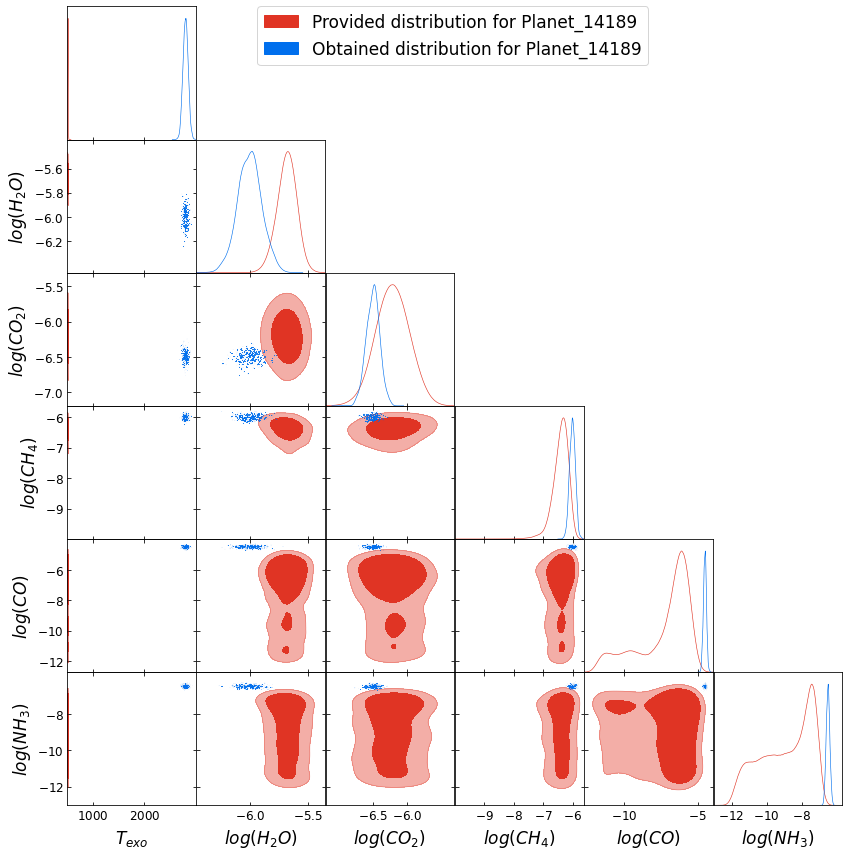

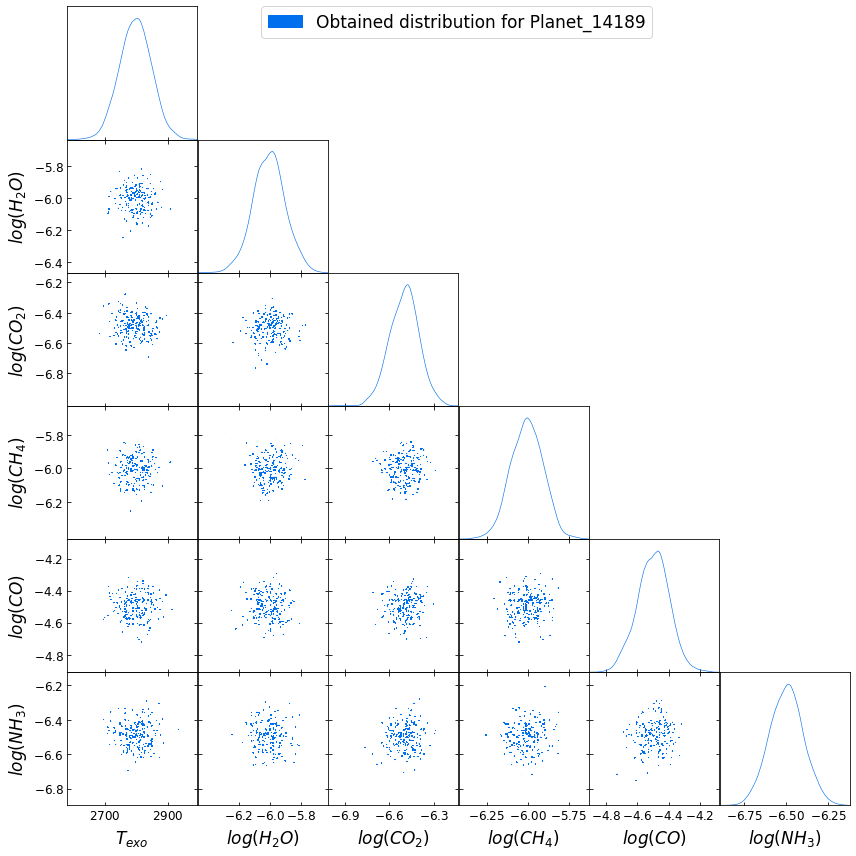

In [67]:
g.triangle_plot([provided_samples, mcsamples], filled=True, legend_labels=['Provided distribution for {0}'.format(planet_id), 'Obtained distribution for {0}'.format(planet_id)])
g.triangle_plot([mcsamples], filled=True, legend_labels=['Obtained distribution for {0}'.format(planet_id)])
